# Imports

In [1]:
import time
import os,pickle
import numpy as np
from matplotlib import pyplot as plt
from numba import njit
from common import numerical_recipes as numrec
from common.baseclasses import AWA
from importlib import reload

import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import RotationalMoM as RotMOM
#from ProbeCavityEigenfields import RotationalMoM_new as RotMOMnew

In [2]:
reload(RotMOM)
RotMOM.quadlimit = int(1e3)
#reload(RotMOMnew)
reload(PCE)

<module 'ProbeCavityEigenfields' from '/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/__init__.py'>

# Narrow Probe

## Probe setup

<ProbeCavityEigenfields.get_probe_radii>:
	Getting geometry for selection "hyperboloid"...
<ProbeCavityEigenfields.RotationalMoM.Discretization.__init__>:
	Discretizing body of revolution over 244 annular nodes and 2 subnodes...
7.336423536064049e-07 0.001889878171401002


Text(0.5, 0, 'z (cm)')

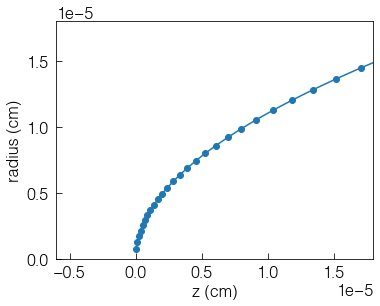

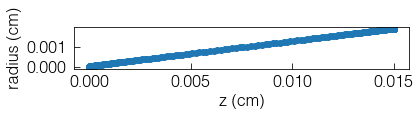

In [282]:
a_nm=60
a=a_nm*1e-7 #in cm
L=150e-4 #probe length in cm
taper_angle=7

WL_THz=300e-4 #300 microns wavelength
freq_THz=1/WL_THz #1 THz
freq=freq_THz

Nsubnodes=2
Nnodes=244
P=PCE.Probe(Nnodes=Nnodes,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                 a=a,taper_angle=taper_angle,geometry='hyperboloid',
            freq=freq,ztip=a)

ztip=P.get_ztip()
zs=P.get_zs()
Rs=P.get_radii()
k=P.get_k()
print(Rs[0],Rs[-1])

plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.xlim(-a,3*a)
plt.ylim(0,3*a)
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.59%	Total quadrature time: 6.55s, time per quadrature evaluation: 1.10E-04s


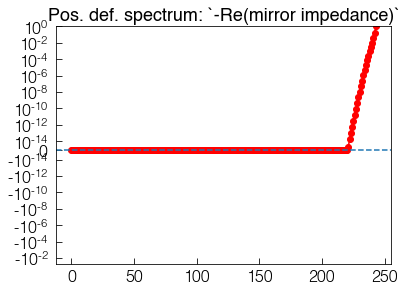

In [283]:
RotMOM.quadlimit = int(1e4)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=0,nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),farfield=False,recompute=True,sommerfeld=True,Nkappas=244*8,rp=rp_au,\
#                                kappa_min=P.get_k()*.01)
Zmirror = P.get_mirror_impedance(k=0,kappa_min=.1/L,recompute=True,sommerfeld=True,Nkappas=244*8)
#Zself = P.get_self_impedance(k=P.get_k(),recompute=True)
rhos,Js = P.solve_eigenmodes(condition_ZM=True,condition_ZS=False,ZMthresh=0,recompute_impedance=False)

Text(0, 0.5, 'Taper: 7')

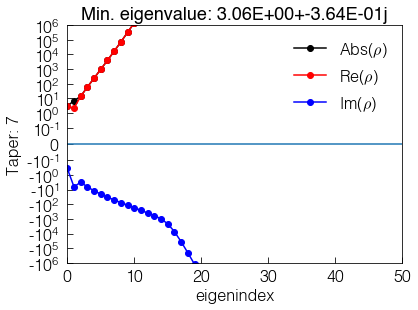

In [284]:
P.plot_eigenrhos()
plt.xlim(0,50)
plt.ylabel('Taper: 7')

## Probe spectroscopy

In [285]:
def PFreq(P,freq,PhiM=True,**kwargs):
    
    print('Starting freq=%1.2f THz'%(freq/freq_THz))
    t0=time.time()
    P.set_freq(freq)
    Zself = P.get_self_impedance(k=P.get_k(),recompute=True,display=False)
    
    if PhiM:
        #Zmirror = P.get_mirror_impedance(k=P.get_k(),recompute=True,\
        #                               sommerfeld=True,rp=None,Nkappas=244*4);
        # Zmirror = P.get_mirror_impedance(k=P.get_k(),nonsingular=False,recompute=True,display=False)
        
        Zmirror = P.get_mirror_impedance(k=P.get_k(),farfield=False,\
                                         recompute=True,sommerfeld=True,Nkappas=244*8)
    
    rhos,Qs = P.solve_eigenmodes(condition_ZM=True,condition_ZS=False,ZMthresh=0,recompute_impedance=False)
    Zmirror = P.get_mirror_impedance(recompute=False)
    print('Finished freq=%1.2f THz, elapsed time: %1.2f'%(freq/freq_THz,time.time()-t0))
    
    return rhos,Qs,Zmirror

def SweepPFreqs(P,freqs,ncpus=8,backend='multiprocessing',**kwargs):
    
    from joblib import Parallel, delayed, parallel_backend
    
    #with Parallel(backend=backend, n_jobs=ncpus) as pool:
    t0=time.time()
    eigensets=[]
    while len(eigensets)<len(freqs):
        nstart=len(eigensets); nstop=len(eigensets)+ncpus
        freqs_sub=freqs[nstart:nstop]
        new_eigensets=Parallel(backend=backend, n_jobs=ncpus)(delayed(PFreq)(P,freq,**kwargs) for freq in freqs_sub)
        print('got results!')
        eigensets=eigensets+new_eigensets
    print('Time elapsed: ',time.time()-t0)
    
    #t0=time.time()
    #Ps=Parallel(n_jobs=ncpus,backend=backend)(delayed(PFreq)(P,freq,**kwargs) for freq in freqs)
    #print('Time elapsed: ',time.time()-t0)
    
    return eigensets

In [309]:
path='ProbeSpectroscopy_Hyperboloid_Taper=%i_L=%1.2E_vsFreq.pickle'%(taper_angle,L)
recompute=False
save=True
overwrite=True

if not recompute and os.path.exists(path):
    with open(path,'rb') as f:
        ProbeSpectroscopy=pickle.load(f)
    
else:
    P=PCE.Probe(Nnodes=Nnodes,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                     a=a,taper_angle=taper_angle,geometry='hyperboloid',
                freq=freq,ztip=a,closed=closed)
    
    PCE.quadlimit=int(1e2)
    ZMirror = P.get_mirror_impedance(k=0,nonsingular=False,recompute=True)

    freqs=np.linspace(.1,3,100)*freq_THz
    eigensets=SweepPFreqs(P,freqs,PhiM=False) #Keep the same QS mirror impedance for all calculations
    
    ProbeSpectroscopy=PCE.Spectroscopy()
    for freq,eigenset in zip(freqs,eigensets):
        rhos,charges,ZMirror=eigenset
        P._eigenrhos=rhos
        P._eigencharges=charges
        P._ZMirror = ZMirror
        ProbeSpectroscopy.record(P,freq)
        
    if save:
        if not os.path.exists(path) or overwrite:
            with open(path,'wb') as f:
                print('Saving!')
                pickle.dump(ProbeSpectroscopy,f)

In [310]:
probe_spectroscopy=ProbeSpectroscopy()
freqs=np.array(sorted(ProbeSpectroscopy.eigenrhos.keys()))
freqs_THz=freqs/freq_THz

(-100000.0, 1000000.0)

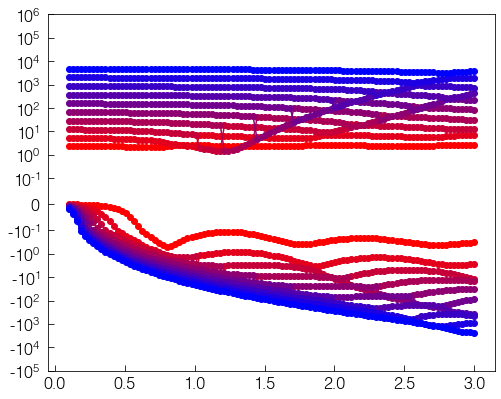

In [311]:
N=10
colors=zip(np.linspace(1,0,N),[0]*N,np.linspace(0,1,N))
plt.figure(figsize=(8,6))

freqs=np.array(sorted(ProbeSpectroscopy.eigenrhos.keys()))
for n in range(N):
    c=next(colors)
    rhos=np.array([ProbeSpectroscopy.eigenrhos[freq][n] for freq in freqs])
    plt.plot(freqs_THz,rhos.real,marker='o',color=c)
    plt.plot(freqs_THz,rhos.imag,marker='o',color=c)
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e5,1e6)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)

Text(0.5, 1.0, 'Narrow probeL L=150.0 microns')

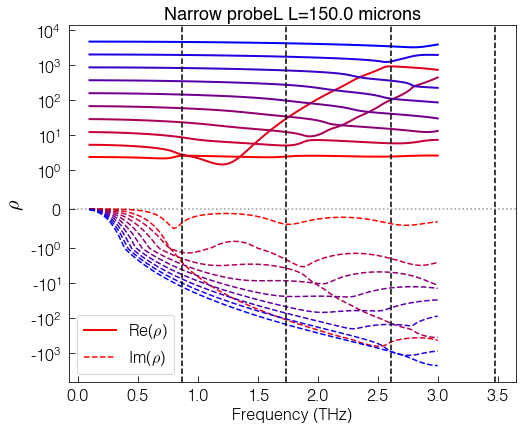

In [312]:
#--- Plot versus coordinates
N=10
colors=zip(np.linspace(1,0,N),[0]*N,np.linspace(0,1,N))

exclude_modes=[]

plt.figure(figsize=(8,6))
for ID in range(N):
    if ID in exclude_modes: continue
    c=next(colors)

    if ID==0:
        label1=r'Re($\rho$)'
        label2=r'Im($\rho$)'
    else: label1=label2=None
    
    rhos=probe_spectroscopy['eigenrhos'][ID]
    plt.plot(rhos.axes[0]/freq_THz,\
             rhos.real,color=c,lw=2,label=label1)
    plt.plot(rhos.axes[0]/freq_THz,\
             rhos.imag,color=c,ls='--',label=label2)
    
plt.gca().set_yscale('symlog',linthreshy=1)
#plt.legend(loc='lower left',ncol=5)

f=.87
plt.axvline(f/(2*L)/freq_THz,color='k',ls='--') #This is where probe ~ lambda/2 antenna - radiative Q?
plt.axvline(f/L/freq_THz,color='k',ls='--') #This is where probe ~ lambda antenna - radiative Q?
plt.axvline(f*3/(2*L)/freq_THz,color='k',ls='--')
plt.axvline(f*2/(L)/freq_THz,color='k',ls='--')
plt.xlabel('Frequency (THz)')
plt.ylabel(r'$\rho$',fontsize=20)
plt.legend(frameon=True)

plt.axhline(0,ls=':',color='k',alpha=.4)
plt.title('Narrow probeL L=%s microns'%(L*1e4))

## Nano-spectroscopy

In [313]:
#Spectroscopy_narrowFreq.set_eigenset(P,freq,update_charges=True)
from NearFieldOptics import Materials as M
rp1 = M.Au.reflection_p #Here's where we can define whatever two reflectivities that we want
rp2 = M.Si.reflection_p
freqs=np.linspace(.1,3,100)*freq_THz

amplitude=80e-7
zmin=a*.0 #no obvious answer for minimum z-distance, we can even put zero
Nmodes=20
Nzs=20
illum_angles=np.linspace(10,80,10)

distance = 100e-4 #nominally the distance (in cm) between two samples-  this will cut-off lower momentum optical interactions
kappa_min = 1 / distance
#kappa_min = None
kwargs=dict(Nkappas=244,kappa_min=kappa_min,kappa_max=np.inf,farfield=False,update_charges=True,\
           update_receptivity=True,update_propogators=True)

S_1 = P.EradSpectrumDemodulated(freqs,zmin=zmin,amplitude=amplitude,\
                                Nzs=Nzs,zquadrature=numrec.CC,\
                                Nmodes=Nmodes,illum_angles=illum_angles,\
                                rp=rp1,demod_order=4,
                                 probe_spectroscopy=ProbeSpectroscopy,\
                                 **kwargs)
S_2 = P.EradSpectrumDemodulated(freqs,zmin=zmin,amplitude=amplitude,\
                                Nzs=Nzs,zquadrature=numrec.CC,\
                                Nmodes=Nmodes,illum_angles=illum_angles,\
                                rp=rp2,demod_order=4,
                                 probe_spectroscopy=ProbeSpectroscopy,\
                                 **kwargs)

S_1['Sn'].set_axes([None,freqs/freq_THz],axis_names=[None,'Frequency (THz)'])
S_2['Sn'].set_axes([None,freqs/freq_THz],axis_names=[None,'Frequency (THz)'])

<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 3.33E+00..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=3.333333333333334...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 4.31E+00..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=4.30976430976431...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 5.29E+00..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=5.28619528619

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=23.838383838383837...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 2.48E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=24.814814814814813...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 2.58E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=25.79124579124579...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Includi

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=45.31986531986533...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 4.63E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=46.2962962962963...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 4.73E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=47.27272727272728...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including 

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=66.80134680134681...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 6.78E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=67.77777777777779...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 6.88E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=68.75420875420875...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=88.28282828282829...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 8.93E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=89.25925925925925...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 9.02E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=90.23569023569024...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=11.144781144781145...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 1.21E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=12.121212121212123...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 1.31E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=13.097643097643099...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Includ

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=32.62626262626262...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 3.36E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=33.602693602693606...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 3.46E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=34.57912457912458...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Includin

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=54.10774410774411...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 5.51E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=55.08417508417509...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 5.61E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=56.06060606060607...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=75.58922558922559...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 7.66E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=76.56565656565657...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 7.75E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=77.54208754208754...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including

<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=97.07070707070707...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 9.80E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=98.04713804713805...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.ProbeSpectroscopy.set_eigenset>:
	Updating eigenrhos to coordinate 9.90E+01..
	Updating eigencharges too..
<ProbeCavityEigenfields.Probe.EradVsZtip>:
	Computing response for ztips at freq=99.02356902356902...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing downwards propogators for 4-potential...
	Including

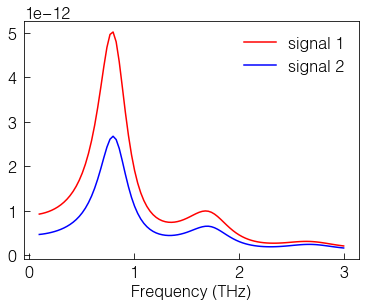

In [314]:
np.abs(S_1['Sn'][3]).plot(color='r',label='signal 1')
np.abs(S_2['Sn'][3]).plot(color='b',label='signal 2')
plt.legend()

Text(0, 0.5, 'Normalized signal')

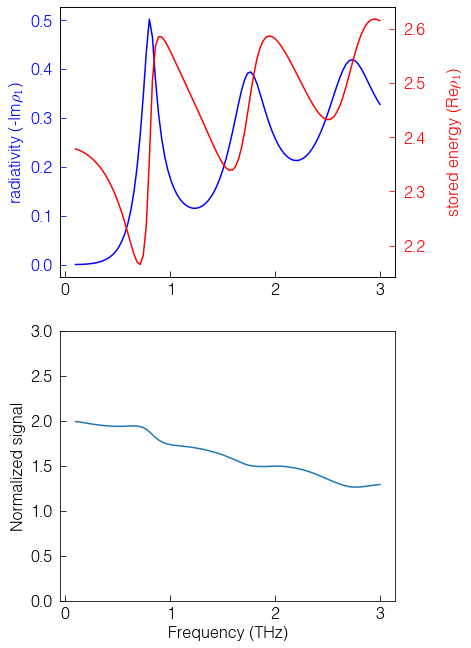

In [315]:
rhos = probe_spectroscopy['eigenrhos'][0]
freqs_THz = rhos.axes[0] / freq_THz

plt.figure(figsize=(6,10))
plt.subplot(211)
plt.plot(freqs_THz,-rhos.imag,color='b')
plt.tick_params(axis='y',colors='b')
plt.ylabel(r'radiativity (-Im$\rho_1$)',color='b')
plt.twinx()
plt.plot(freqs_THz,+rhos.real,color='r')
plt.tick_params(axis='y',colors='r')
plt.ylabel(r'stored energy (Re$\rho_1$)',color='r',labelpad=20)

plt.subplot(212)
np.abs(S_1['Sn']/S_2['Sn'])[3].plot()
#plt.xlim(0,2000)
plt.ylim(0,3)
plt.ylabel('Normalized signal')